# PD, ICE and Interaction Detection Tutorial

The following script gives examples of the main functions available in the ice-pd. This includes creating ensembles, producing PD plots (with ensemble variance shown, and OHE available) and ICE plots and detecting interactions. The interaction detection uses PD and H-statistics, with a null values for the H-statistic also calculated.

The Boston housing dataset is used as an example, with the house price predicted from features such as the number of rooms in the property (see https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html for further info.). 


In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.datasets import load_boston
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import matplotlib
import matplotlib.pyplot as plt

from icepd.interactions import OLS_interactions, l1_interactions
from icepd.partial_dep import pd_plot, pd_hstat_compare, plot_interactions, pd_hstat, pd_hstat_null, pd_OHE_1D_plot, plot_format

from icepd.ice import ice_plot
from icepd.data_struct import Ensemble
from sklearn.kernel_ridge import KernelRidge

The Boston housing dataset is then loaded from scikit-learn:

In [2]:
#Load example data
X, y = load_boston(return_X_y=True)
bost_dic = load_boston()

The variables are then scaled and the RAD variable is one-hot encoded.

In [3]:
# Change to pd dataframe, center and scale to unit std
[mean_x4, std_x4] = [X[:,4].mean(), X[:,4].std()] 
[mean_y, std_y] = [y.mean(), y.std()] 
X = pd.DataFrame(scale(X))
y = pd.DataFrame(scale(y))
X.columns = bost_dic['feature_names']



A KRR model is created, and an ensemble of KRR fit to the training set. 

Training error 0.24056088689303817
Testing error 0.24567800127586106


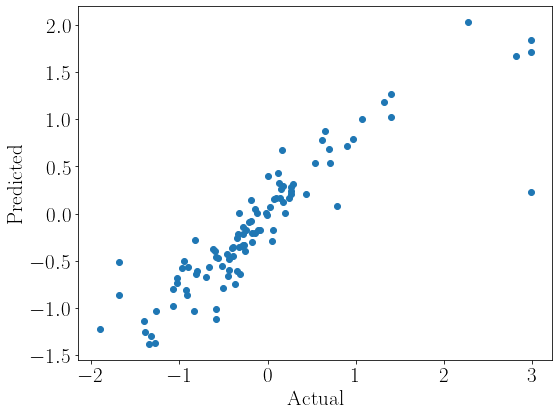

In [4]:
# KRR initalized 
model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)

# Create and fit an ensemble model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model_ensem = Ensemble(model) # When initializing pass Ensemble class the model type                  
model_ensem.fit(X_train, y_train, N=10) # Number of items in ensemble

print('Training error ' + str(abs(y_train.values.ravel() - model_ensem.predict(X_train).ravel()).mean()))
print('Testing error ' + str(abs(y_test.values.ravel() - model_ensem.predict(X_test).ravel()).mean()))

plot_format()
plt.scatter(y_test.values.ravel(), model_ensem.predict(X_test).ravel())
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Save ensemble
model_ensem.save('./Models/model_ensem_Boston_KRR_')

Prefit models can also be loaded instead:

In [5]:
# The model ensemble can also be set with an existing array of regression models
model_array = [pickle.load(open('./Models/model_ensem_Boston_KRR_' + str(i) + '.h5', 'rb')) for i in range(0,10)]
model_ensem.set_models_array(model_array)

## Partial Dependence Plots

Partial dependence plots, with the ensemble variance showing the uncertainity, for the variable NOX (describing nitrious oxide concentrations) can be produced as follows:

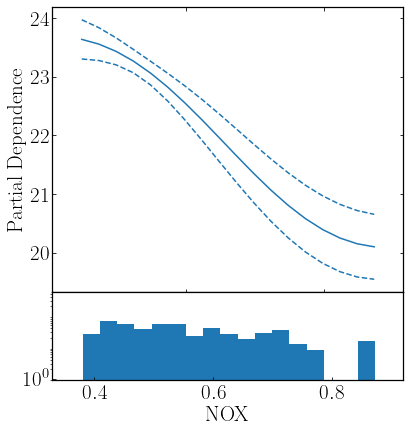

In [6]:
# Plot 1D PD plot, unscaled
pdp = pd_plot(X, y, [4], model_ensem, center='N', ensemble='Y', grid_size = 0.25, linear='N', grad='N', filename='./Graphs/Unscaled_', unscale_x=[mean_x4, std_x4], unscale_y=[mean_y, std_y], show='Y')
plt.show()

PD plot for OHE variable can also be created, with the errorbars corresponding to the variance of the ensemble:

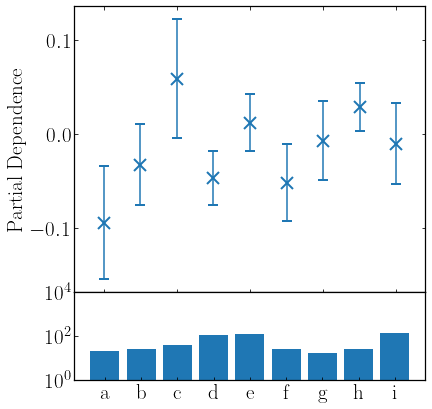

In [7]:
# OHE RAD variable
one_hot = pd.get_dummies(X['RAD'], prefix=('RAD'))
X_ohe = X.copy().drop(columns = 'RAD')
X_ohe = X_ohe.merge(one_hot, left_index=True, right_index=True, how='left')

#X_ohe.columns = [c.replace('_', ' ')[4:8] for c in X_ohe.columns]

# Create and fit an ensemble model
X_ohe_train, X_ohe_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.20, random_state=42)
model_ensem_ohe = Ensemble(model) # When initializing pass Ensemble class the model type                  
model_ensem_ohe.fit(X_ohe_train, y_train, N=10) # Number of items in ensemble

# Plot 1D PD plot for OHE variable
pdp = pd_OHE_1D_plot(X_ohe,y, [12,13,14,15,16,17,18,19,20], model_ensem_ohe, ensemble='Y', filename='./Graphs/', xtick_labels=['a','b','c','d','e','f','g','h','i'], show='Y')
plt.show()

A 2D PD plot is shown below: 

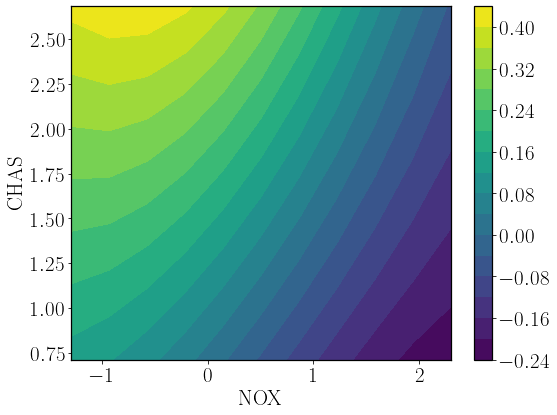

In [8]:
# Plot 2D PD plot
plt.close()
pdp = pd_plot(X, y, [3,4], model_ensem, ensemble='Y', filename='./Graphs/', show='Y')  
plt.show()

## ICE Plots
ICE plots can be produces as follows:

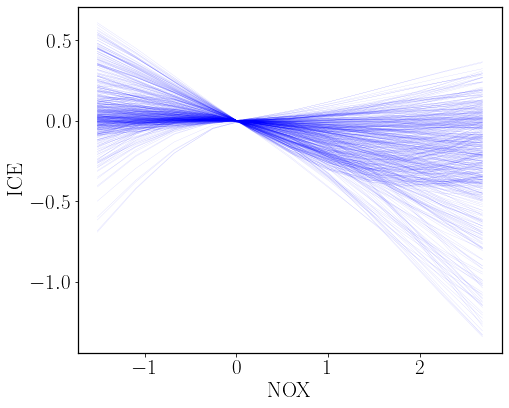

In [9]:
ice = ice_plot(X, [4], model_ensem.models_array[0], ensemble='N', grad='N', alpha=0.5, center='Y', filename='./Graphs/', show='Y')
plt.show()

A large variation in the behaviour can be seen, pointing to interactions or unphysical behaviour in extrapolation regions. 

## Interaction Detection with H-statistics

Partial dependence measure can be used to detect if an interaction exist. To do this properly, the H-statistic for a purely additive dataset should also be found (otherwise it is not possible to tell if the interactions you are seeing are just noise). The number of datapoints the H-statistic is calculated for is controlled by N/N_pd. 


In [10]:
h_stat_one, pd_dict = pd_hstat([1,12], X, model_ensem, N=500)

# Null distribution H stats
mean_h_null_one, std_h_null_one, h_null_one, art_data= pd_hstat_null(X, y, model_ensem.models_array[0], features=[1,12], N_pd=500, N_null=10)

print('The H-statistic for the actual dataset: ' + str(h_stat_one))
print('The H-statistic for the null dataset: ' + str(mean_h_null_one) + ' with std. ' + str(std_h_null_one))



Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   11.3s finished


Finished fitting artificial data
The H-statistic for the actual dataset: 0.24933962121997716
The H-statistic for the null dataset: 0.20162749062259647 with std. 0.01851594359473405


If the H-statistics is larger that null value by several standard deviations, we can conclude that an interaction does exist in the model. 

To compute all interactions in the model and then plot them, we can do the following (this may take a couple of minutes): 

In [ ]:
# Interactions for all variables
h_stat, h_stat_null_m, h_stat_null_std = pd_hstat_compare(X,y, model_ensem, N=500) # The number of points sampled for the H-statistic can be set here 

print(h_stat_null_m)
print(h_stat_null_std)

print(h_stat)

# Subtract the null value and set those less than 4 std. from mean to zero
params = h_stat - h_stat_null_m
params[(params) < 4*h_stat_null_std] = 0 

plot_interactions(params, X, 'H-Stat', show='Y')
plt.show()

And that is a basic overview of how to create PD and ICE plots and how to view interactions! If you use this code please cite : .... and if you have problems you can email alice.allen@uni.lu